In [1]:
import numpy as np
import pandas as pd
from fyers_apiv3 import fyersModel
from config import CLIENT_ID, AUTH_CODE, REDIRECT_URI, RESPONSE_TYPE, STATE, SECRET_KEY, GRANT_TYPE, get_logger

# --- Exchange auth_code for access_token ---
session = fyersModel.SessionModel(
    client_id=CLIENT_ID,
    secret_key=SECRET_KEY,
    redirect_uri=REDIRECT_URI,
    response_type=RESPONSE_TYPE,
    state=STATE,
    grant_type=GRANT_TYPE
)

session.set_token(AUTH_CODE)
response = session.generate_token()

access_token = response.get("access_token")
print(access_token)
if not access_token:
    raise SystemExit("Exiting: Could not retrieve access_token")

# --- Initialize Fyers client ---
fyers = fyersModel.FyersModel(
    token=access_token,
    is_async=False,
    client_id=CLIENT_ID
)

# --- Example: Historical data for backtesting ---
data = {
    "symbol": "NSE:RELIANCE-EQ",
    "resolution": "10",       
    "date_format": "1",       # YYYY-MM-DD
    "range_from": "2024-01-01",
    "range_to": "2024-03-31",
    "cont_flag": "1"
}

history = fyers.history(data=data)

# --- Convert to DataFrame ---
import pandas as pd
from zoneinfo import ZoneInfo  

if history.get("s") == "ok":
    print("History data found.")
    candles = history["candles"]
    
    # Create DataFrame
    df = pd.DataFrame(candles, columns=["date", "open", "high", "low", "close", "volume"])
    df["date"] = pd.to_datetime(df["date"], unit="s", utc=True)
    df["date"] = df["date"].dt.tz_convert(ZoneInfo("Asia/Kolkata"))
    df.set_index("date", inplace=True)
    
    # Reorder columns to OCLHV format
    df = df[["open", "close", "low", "high", "volume"]]
else:
    print("Error fetching history:", history)


eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJhdWQiOlsiZDoxIiwiZDoyIiwieDowIiwieDoxIiwieDoyIl0sImF0X2hhc2giOiJnQUFBQUFCbzFpRDY2ZE1IYjdld0FyLWJHRlBCcXAtSG00QnUtZzh2emdHVV9oQ1BMQWVmZExab0VjVzcxLU9OZUVTZUhMYUFCdU9tRkdzTlF1M1RlYWVvcGdESm5iekplMkhIYy1meVh3dlpxUHZOT3NsV3NpRT0iLCJkaXNwbGF5X25hbWUiOiIiLCJvbXMiOiJLMSIsImhzbV9rZXkiOiIwYTBmMzg1MzQwN2M1NmMwYjc1ODU1NjYzZmE3M2M4NzRlY2IyYTRjMjU2ZGQ5Mzk0YWVjZGQwNSIsImlzRGRwaUVuYWJsZWQiOiJOIiwiaXNNdGZFbmFibGVkIjoiTiIsImZ5X2lkIjoiRkFDNjIzNDQiLCJhcHBUeXBlIjoxMDAsImV4cCI6MTc1ODkzMzAwMCwiaWF0IjoxNzU4ODYzNjEwLCJpc3MiOiJhcGkuZnllcnMuaW4iLCJuYmYiOjE3NTg4NjM2MTAsInN1YiI6ImFjY2Vzc190b2tlbiJ9.pzY7Nc2jGOv5eHLHD7jky_9wuY7owNVcxhN_Smc3aHc
History data found.


In [11]:
df.head(), df.shape

(                              open    close      low     high  volume
 date                                                                 
 2024-01-01 09:15:00+05:30  1290.28  1289.72  1288.33  1295.13  235758
 2024-01-01 09:25:00+05:30  1289.63  1289.75  1286.58  1290.40  161684
 2024-01-01 09:35:00+05:30  1290.00  1291.03  1287.55  1292.00  122594
 2024-01-01 09:45:00+05:30  1291.03  1293.10  1291.00  1293.72  113256
 2024-01-01 09:55:00+05:30  1292.50  1291.65  1291.45  1293.18   95866,
 (2330, 5))

In [4]:
from indicators import *
from strategies import *
from portfolio import Portfolio

signal = cross_over(df, EMA(df, 15), EMA(df, 40))

In [12]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['close'],
    mode='lines',
    name='Close Price',
    line=dict(color='royalblue', width=2)
))

# Buy Signals
fig.add_trace(go.Scatter(
    x=df.index[signal == 1],
    y=df['close'][signal == 1],
    mode='markers',
    name='Buy Signal',
    marker=dict(symbol='triangle-up', size=12, color='green')
))

fig.add_trace(go.Scatter(
    x=df.index[signal == -1],
    y=df['close'][signal == -1],
    mode='markers',
    name='Sell Signal',
    marker=dict(symbol='triangle-down', size=12, color='red')
))

fig.update_layout(
    title='Stock Close Price with Buy/Sell Signals',
    xaxis_title='Date',
    yaxis_title='Close Price',
    template='plotly_dark',
    hovermode='x',
    legend=dict(x=0.01, y=0.99)
)

fig.show(renderer="browser")


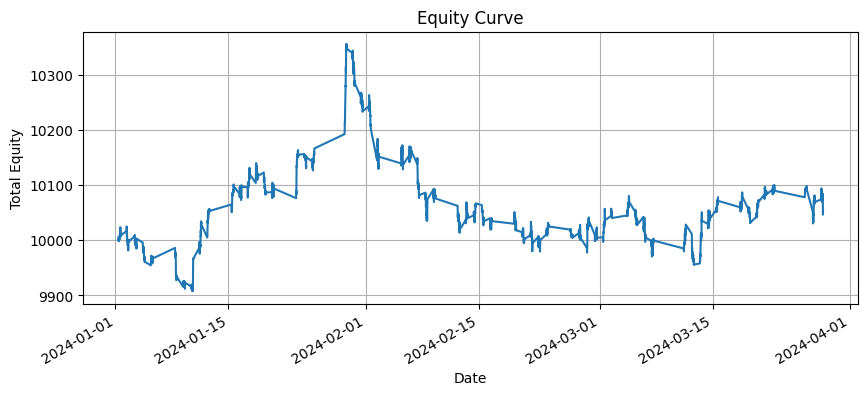

In [13]:
backtest = Portfolio(df, signal, 10000, intraday = True,commission=0, slippage=0)
backtest.simulate()
backtest.plot_equity()

In [14]:
backtest.metrics()

{'Total Return (%)': 0.55,
 'CAGR (%)': 2.35,
 'Volatility': 0.01,
 'Sharpe Ratio': 0.07,
 'Max Drawdown (%)': -3.86,
 'Win Rate (%)': 48.95,
 'Profit Factor': 1.01}

In [15]:
md = backtest.analyse()
md.head()

,Total Return,CAGR,Volatility,Sharpe Ratio,Max Drawdown,Win Rate,Profit Factor
date,,,,,,,
2024-01-01 09:25:00+05:30,0.000000,0.000000,NaN,NaN,0.00000,0.000000,NaN
2024-01-01 09:35:00+05:30,0.000206,0.000206,0.002312,11.224972,0.00000,0.500000,NaN
2024-01-01 09:45:00+05:30,0.000620,0.000620,0.003285,15.849973,0.00000,0.666667,NaN
2024-01-01 09:55:00+05:30,0.000330,0.000330,0.004767,4.362567,-0.00029,0.500000,2.138962
2024-01-01 10:05:00+05:30,0.000160,0.000160,0.004501,1.793463,-0.00046,0.400000,1.348332


In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

pio.renderers.default = "browser"

percent_cols = ["Total Return", "CAGR", "Max Drawdown", "Win Rate"]

# Create subplots
fig = make_subplots(
    rows=len(md.columns),
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=[f"{col} Over Time" for col in md.columns]
)

for i, col in enumerate(md.columns, start=1):
    y = md[col]
    
    if col in percent_cols:
        y = y * 100
    
    fig.add_trace(
        go.Scatter(
            x=md.index,
            y=y,
            mode='lines+markers',
            name=col,
            hovertemplate="%{y:.4f}" + ("%" if col in percent_cols else "") + "<extra></extra>",
            line=dict(width=2)
        ),
        row=i,
        col=1
    )
    
    fig.update_yaxes(title_text="%" if col in percent_cols else col, row=i, col=1)

fig.update_layout(
    height=350*len(md.columns),
    title_text="Backtest Metrics Over Time",
    template="plotly_dark",
    hovermode="x unified"
)

fig.update_xaxes(title_text="Date", row=len(md.columns), col=1)

fig.show()